# Step 3: combine signals found in step 2, cluster, visualize


In [30]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Mythical code button"></form>''')

In [31]:
import arrow
import netCDF4 as nc
import glob
from matplotlib import pyplot as plt
import numpy as np
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import fcluster


#### Open files from ./DATASETS and combine into a single array of size (no.stations)x(days-of-year)
#### Save this into ./DATASETS/DEPTHINT_MESOZOO_FULLYEAR.nc



In [16]:
## turn this to false if you've already done the extraction!

extract = True
ncstring = 'DEPTHINT_MESOZOO_'
num_stations = 611
days_in_year = 366
signalmat = np.zeros([num_stations,days_in_year])

start ='2012-01-01'
end ='2012-12-31'

if extract:

    start_run = arrow.get(start)
    end_run = arrow.get(end)

    arrow_array = []

    for r in arrow.Arrow.span_range('day', start_run, end_run):
        arrow_array.append(r)

    dayslen = len(arrow_array)    

    for i in range(0,dayslen):
        tdate = arrow_array[i][0]
        
        ymd = tdate.format('YYYYMMDD')

            #open the signal matrix for one day
        ncname = nc.Dataset(f'./DATASETS/{ncstring}{ymd}.nc')
        #put in signalmat
        signalmat[:,i] = ncname['depthint_mesozoo'][:]
        

    ncname = f'./DATASETS/{ncstring}FULLYEAR.nc'
    f = nc.Dataset(ncname,'w', format='NETCDF4') #'w' stands for write
    #g = f.createGroup('model_output')
    f.createDimension('stn', num_stations)
    f.createDimension('days',days_in_year)
    #data.createVariable('N', np.float32, ('z','x','y'))
    ts2 = f.createVariable('depthint_mesozoo',np.float32,('stn','days'))
    ts2[:] = signalmat
    f.close()

## Open the combined matrix and plot the signals, just to look at them
### the matrix of 611 stations x 366 days in the year is called signalmat

In [18]:
tsig = nc.Dataset(f'./DATASETS/{ncstring}FULLYEAR.nc')
print(tsig)
signalmat = tsig['depthint_mesozoo'][:]

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    dimensions(sizes): stn(611), days(366)
    variables(dimensions): float32 depthint_mesozoo(stn,days)
    groups: 



Text(0, 0.5, 'mmol N/m2 mesozooplankton')

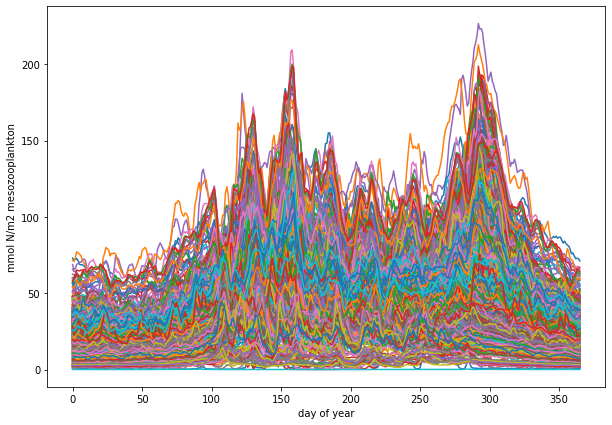

In [27]:
fact = 0.5

fig, axs = plt.subplots(1,1, figsize=(20*fact, 14*fact), facecolor='w', edgecolor='k')

for i in range(0,611):
    axs.plot(np.arange(0,366,1), signalmat[i,:])

axs.set_xlabel('day of year')
axs.set_ylabel('mmol N/m2 mesozooplankton')

# clustering using scipy - save the clustermat

In [34]:

Z = linkage(signalmat, 'ward')
print(np.shape(Z))

clustermat = np.zeros([100,num_stations])                           
for k in range(0,100): 
    clustermat[k,:] = fcluster(Z, k+1, criterion='maxclust')

ncname = f'./DATASETS/{ncstring}CLUSTERMATRIX.nc'
f = nc.Dataset(ncname,'w', format='NETCDF4') #'w' stands for write
#g = f.createGroup('model_output')
f.createDimension('stn', num_stations)
f.createDimension('clusts',100)
#data.createVariable('N', np.float32, ('z','x','y'))
ts2 = f.createVariable('clustermatrix',np.float32,('clusts','stn'))
ts2[:] = clustermat
f.close()

# pickle.dump(clustermat, open('./pkls/bio_clustmat_'+year+'.pkl', 'wb'))

(610, 4)


In [36]:
coords = nc.Dataset('./DATASETS/X_AND_Y_COORDS.nc')
print(coords)
xcoords = coords['stn_xcoords'][:]
ycoords = coords['stn_ycoords'][:]

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    dimensions(sizes): ref(611)
    variables(dimensions): float32 stn_ycoords(ref), float32 stn_xcoords(ref)
    groups: 



In [39]:
grid = nc.Dataset('//data/tjarniko/MEOPAR/grid/mesh_mask201702.nc')
print(grid['fmask'][0,0,:,:])

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


## functions for visualizing clusters

In [58]:


def clusters(ax1,clustermat,no_clusters, markersize = 20, legfontsize = 12 ):

              
    colors = ['deepskyblue','red','gold','forestgreen',
    'midnightblue','orchid','gray','peru',
    'olive','sandybrown','teal','pink','tan',
    'yellow','thistle']
    
    import pickle
    import numpy as np
    import cmocean as cm
    import sys
    from salishsea_tools import (
    viz_tools)
    
    cl_this = clustermat[no_clusters-1,:]
    np.shape(cl_this)
    
#     bath = '/results/nowcast-sys/NEMO-forcing/grid/mesh_mask_SalishSea2.nc'

    grid = nc.Dataset('//data/tjarniko/MEOPAR/grid/mesh_mask201702.nc')


    viz_tools.set_aspect(ax1)   
    fmask = (grid['fmask'][0,0,:,:])    
    mesh = ax1.pcolormesh(fmask, vmin=0, vmax=1, cmap = cm.cm.deep)

    ###sort clusters by size
    cluster_ids = np.arange(1,no_clusters+1,1)
    cluster_sizes = np.zeros_like(cluster_ids)
    
    #retrieve cluster sizes
    for j in range(1,no_clusters+1):
        cluster = np.where(cl_this == j)
        cluster = np.squeeze(cluster)
        cluster_sizes[j-1] = (np.size(cluster))
    
   #sort cluster size matrix biggest to smallest
    cs = np.argsort(-cluster_sizes)
    #print(cs)

    #use those sizes to sort the cluster id list to corresponde to a list 'clust id, largest to smallest'
    new_cidlist = np.zeros_like(cluster_ids)
    for j in range(0,len(new_cidlist)):
        new_cidlist[j] = cluster_ids[cs[j]]

    #start plotting, plotting biggest cluster first, to keep colour order the same
    for j in range(0,np.size(new_cidlist)):

        cluster = np.where(cl_this == new_cidlist[j])
        cluster = np.squeeze(cluster)
        
        
        c1_x = np.take(xcoords,cluster)
        c1_y = np.take(ycoords,cluster)
        pts = ax1.scatter(c1_x,c1_y,s=markersize,c=colors[j], label=str(new_cidlist[j]), marker='o')
        ax1.set_xticklabels( () ) 
        ax1.set_yticklabels( () ) 
    
    tit = f'Mesozoo clustering, n. clusters = {no_clusters}'
    ax1.legend(bbox_to_anchor=(1.1, 1), fontsize = legfontsize)
    ax1.set_title(tit,fontsize = legfontsize + 2)

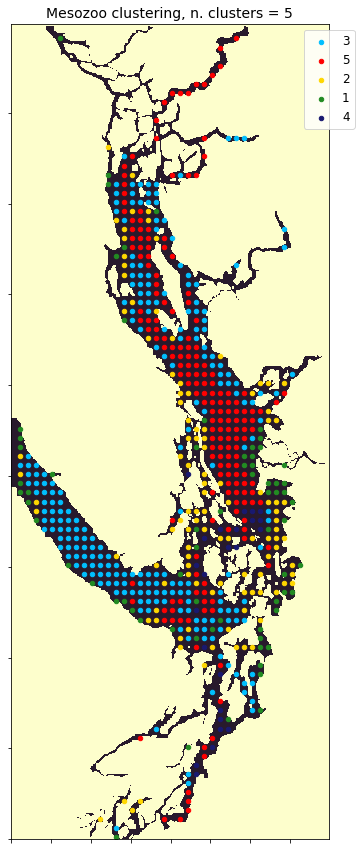

In [59]:
fig, ax1 = plt.subplots(1,1, figsize=(20*fact, 30*fact), facecolor='w', edgecolor='k')
clusters(ax1,clustermat,5, markersize = 20, legfontsize = 12 )


# Show mean patterns using the mean pattern extraction function

currently you have to assign colours manually based on the graph above(because cluster designation is assigned randomly) -could be automated.


In [61]:
def cluster_patterns_mean(orig_data,clustermat,no_clusters,cluster_in_question,days_in_year):
    import numpy as np
    
    '''For a given data matrix (S stations X 365 daily signals), list of clusters designation (S stations), 
    and specific cluster, return an C_S x 365 matrix of the C_S annual signals in that cluster
    for the C_S stations in the cluster'''
    #which stations are in the cluster we are looking for?
    cluster_des = clustermat[no_clusters-1,:]
    
    where_cluster = np.where(cluster_des == cluster_in_question)
    where_cluster = np.squeeze(where_cluster)
#     print(where_cluster.shape)
#     print(where_cluster.size)

    
    no_stns_in_cluster = where_cluster.size
    if no_stns_in_cluster == 1:
        this_stn = np.squeeze(where_cluster)
        where_cluster = this_stn
        signalmat = orig_data[this_stn,:]
        mean_signal = signalmat
    else:    
    
        this_cluster_mat = np.zeros([no_stns_in_cluster,days_in_year])

        for stn in range(0,no_stns_in_cluster):

            this_stn = where_cluster[stn]
            this_cluster_mat[stn,:] = orig_data[this_stn,:]
        mean_signal = np.nanmean(this_cluster_mat, axis = 0)
    return mean_signal


this_mean = cluster_patterns_mean(signalmat,clustermat,5,1,366)


In [60]:
cl_1_mean = cluster_patterns_mean(signalmat,clustermat,5,1,366)
cl_2_mean = cluster_patterns_mean(signalmat,clustermat,5,2,366)
cl_3_mean = cluster_patterns_mean(signalmat,clustermat,5,3,366)
cl_4_mean = cluster_patterns_mean(signalmat,clustermat,5,4,366)
cl_5_mean = cluster_patterns_mean(signalmat,clustermat,5,5,366)

(68,)
68
(109,)
109
(224,)
224
(24,)
24
(186,)
186


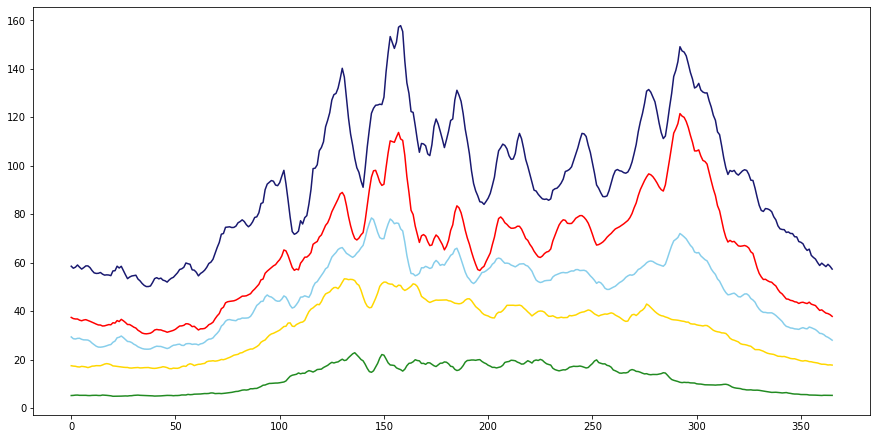

In [64]:
fig, ax1 = plt.subplots(1,1, figsize=(30*fact, 15*fact), facecolor='w', edgecolor='k')

ax1.plot(np.arange(0,366,1),cl_1_mean, color = 'forestgreen')
ax1.plot(np.arange(0,366,1),cl_2_mean, color = 'gold')
ax1.plot(np.arange(0,366,1),cl_3_mean, color = 'skyblue')
ax1.plot(np.arange(0,366,1),cl_4_mean, color = 'midnightblue')
ax1.plot(np.arange(0,366,1),cl_5_mean, color = 'red')

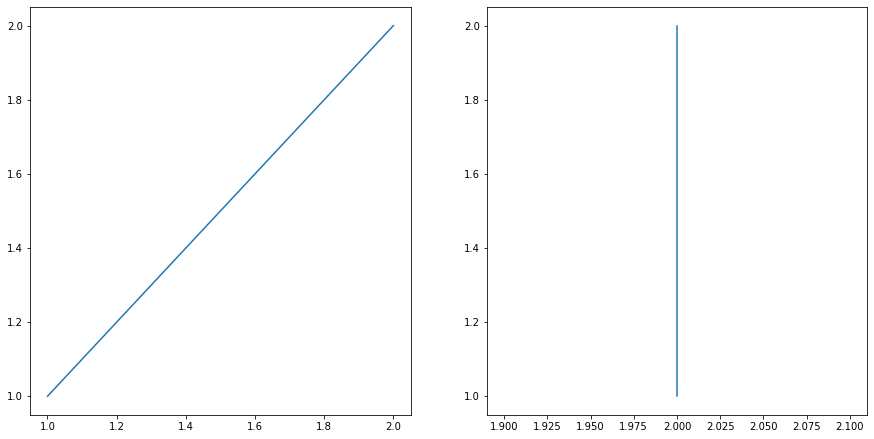

In [67]:
fig, axs = plt.subplots(1,2, figsize=(30*fact, 15*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()
axs[0].plot([1,2],[1,2])
axs[1].plot([2,2],[1,2])

In [70]:
type(fig)

matplotlib.figure.Figure